In [1]:
# Include libraries which may use in implementation
import numpy as np
import random
import math
import pickle
import json
from sklearn.utils import shuffle
import glob
import cv2 
import time
import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score
%matplotlib inline


# Loading MNIST dataset

In [2]:
def loadDataset(path):
    print('Loading Dataset...')
    train_x, train_y, test_x, test_y = [], [], [], []
    for i in range(10):
        for filename in glob.glob(path + str(i)+'\\*.png'): #+ '\\train\\' 
            im = cv2.imread(filename,0) #reading in greyscale
            train_x.append(im)
            train_y.append(i)
    for i in range(10):
        for filename in glob.glob(path2  + str(i)+'\\*.png'): #+ '\\test\\'
            im=cv2.imread(filename,0)
            test_x.append(im)
            test_y.append(i)
    print('Dataset loaded...')
    return np.array(train_x), np.array(train_y), np.array(test_x),np.array(test_y)


In [5]:
# path = 'D:\study material\MSDS-ITU\semester2\DL\Assignments\Assignment2\Task3_DataFull'
path = 'D:Assignment\data'
train_set_x, train_set_y, test_set_x, test_set_y = loadDataset (path)

Loading Dataset...
Dataset loaded...


In [6]:
print( "train_set_x.shape : ",train_set_x.shape ,"\n train_set_y.shape: ", train_set_y.shape,"\n test_set_x.shape: ", test_set_x.shape, "\n  test_set_y.shape :",test_set_y.shape, "\n")

train_set_x.shape :  (28, 28, 28) 
 train_set_y.shape:  (28,) 
 test_set_x.shape:  (30, 28, 28) 
  test_set_y.shape : (30,) 



In [7]:
#Converting into our required dimensions given in pdf
train_set_y=np.expand_dims(train_set_y, axis=1)
test_set_y = np.expand_dims(test_set_y, axis=1)
train_set_x=np.expand_dims(train_set_x, axis=3)
test_set_x = np.expand_dims(test_set_x, axis=3)
print( "train_set_x.shape : ",train_set_x.shape ,"\n train_set_y.shape: ", train_set_y.shape,"\n test_set_x.shape: ", test_set_x.shape, "\n  test_set_y.shape :",test_set_y.shape, "\n")

train_set_x.shape :  (28, 28, 28, 1) 
 train_set_y.shape:  (28, 1) 
 test_set_x.shape:  (30, 28, 28, 1) 
  test_set_y.shape : (30, 1) 



In [8]:
def Encode(l):
    no_of_classes = 10
    c = np.arange(no_of_classes)
    one_hot = (c == l).astype(np.int)
    return one_hot

In [9]:
def split_encode(train_set_x,train_set_y,test_set_x, test_set_y):
    trainPercentage = 0.75
    testPercantage= 0.25
    
    train_set_y=Encode(train_set_y)
    testY = Encode(test_set_y)
    
    X, y = shuffle(train_set_x, train_set_y)
    test_set_x,testY = shuffle(test_set_x,testY)
    
    trainX = X[:int(trainPercentage * len(X))] # training data point
    trainY = y[:int(trainPercentage * len(y))] # training lables

    validX = X[int(trainPercentage * len(X)) :  ] # validation data point
    validY = y[int(trainPercentage * len(y))  : ]# validation lables
    
    return trainX,trainY,validX,validY,test_set_x,testY

In [20]:
trainX,trainY,validX,validY,testX,testY = split_encode(train_set_x,train_set_y,test_set_x, test_set_y)

In [21]:
print("trainX,trainY,validX,validY,testX,testY >> \n", trainX.shape,trainY.shape,validX.shape,validY.shape,testX.shape,testY.shape)

trainX,trainY,validX,validY,testX,testY >> 
 (21, 28, 28, 1) (21, 10) (7, 28, 28, 1) (7, 10) (30, 28, 28, 1) (30, 10)


In [25]:
# Create a Neural_Network class
class Neural_Network(object):    
    def __init__(self,no_of_layers = 2, input_dim = 1296, neurons_per_layer =[600,160,10],nf =1,depth=1,w=1):        
        # size of layers
        self.inputSize = input_dim
        self.depth = depth
        #NNweights
        self.W1 = np.random.randn(self.inputSize,neurons_per_layer[0] )
        self.b1 = np.ones((1,neurons_per_layer[0]))
        self.W2 = np.random.randn(neurons_per_layer[0],neurons_per_layer[1] )
        self.b2 = np.ones((1,neurons_per_layer[1]))
        self.W3 = np.random.randn(neurons_per_layer[1], neurons_per_layer[2] )
        self.b3 = np.ones((1,neurons_per_layer[2]))
        #cnnWeights
        self.cnnfilters = self.createFilters(nf,self.depth,w) #3 filters of 3 X 3 with given depth=4
        self.cnnbiases = self.createFilters(nf,self.depth,1)
        self.errorTrain =[]
        self.errorValid =[]
        self.ValidationAccuracy =[]
        self.TraingingAccuracy = []


    def plotFilters(self,depth, data):
        for i in range(depth):
            plt.subplot(6,6,i+1)
            plt.axis('off')
            plt.imshow(data[:,:,i], cmap = 'gray')
            
    def RandomlyInitilizeFilters(self,depth, w):
        output = np.zeros((depth,w,w))
        for i in range(depth):
            output[i] = np.random.randn(w,w)
        output = np.rollaxis(output, 0,3)
        return output
    
    def createFilters(self,numOfFilters,depth,w):
        output = []
        for i in range(numOfFilters):
            filters = self.RandomlyInitilizeFilters(depth,w)
    #         plotFilters(filters.shape[2], filters)
            output.append(filters)
        output = np.array(output)
        print(output.shape)
        return output    
    
    def Encode(self,l):
        c = np.arange(10)
        one_hot = (c == l).astype(np.int)
        return one_hot    
    
    def feedforward(self, X):
        
        self.l1 = np.dot(X, self.W1) + self.b1 
        self.a1 = self.sigmoid(self.l1)
        self.l2 = np.dot(self.a1, self.W2) + self.b2  
        self.a2 = self.sigmoid(self.l2)
        self.l3 = np.dot(self.a2, self.W3) + self.b3 
        self.a3 = self.softmax(self.l3)

        return self.a3
        
    def softmax(self, X):
        exps = np.exp(X - np.max(X))
        return exps / np.sum(exps, axis=1, keepdims= True)

    def softmax_derivative(softmax):
        s = softmax.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    def sigmoid(self, x):
        # activation function
        sig_x = np.zeros(x.shape)
        
        # protection from overflow and underflow
        low_x = -30
        up_x  = 30
        
        sig_x[x< low_x]=0
        sig_x[x> up_x ]=1
        
        safe_x = x[(x>= low_x) & (x<= up_x)]
        sig_x[(x>= low_x) & (x<= up_x)] = np.exp(safe_x)/(1+np.exp(safe_x))
          
        return sig_x
        # return (1/ (1 + np.exp(-s))) # apply sigmoid function on s and return it's value

    def sigmoid_derivative(self, s):
        #derivative of sigmoid
#         s = self.sigmoid(s)
        sigmoidDerivative = s * (1 - s)
        return sigmoidDerivative # apply derivative of sigmoid on s and return it's value 
    
    def backwardpropagate(self,X, Y, y_pred, lr):
        L3 = (y_pred- Y)
        norm = 1/X.shape[0]
        dw3 = np.dot(self.a2.T, L3) * norm
        db3 = np.sum(L3, axis=0, keepdims = True)* norm
        da2 =self.sigmoid_derivative(self.a2)
        L2 = np.multiply(np.dot(L3,self.W3.T),da2 )
        dw2 = np.dot(self.a1.T, L2)* norm
        db2 = np.sum(L2, axis=0, keepdims = True)* norm
        da1 = self.sigmoid_derivative(self.a1)
        L1 = np.multiply(np.dot(L2,self.W2.T),da1 )
        dw1 = np.dot(X.T, L1)* norm
        db1 = np.sum(L1, axis=0, keepdims = True)* norm
        
        L0 = np.dot(L1,self.W1.T)
        
        self.W1 -= lr * dw1
        self.b1 -= lr * db1
        self.W2 -= lr * dw2
        self.b2 -= lr * db2
        self.W3 -= lr * dw3
        self.b3 -= lr * db3
        
#         print("L0>> ",L0.shape,"L1 >> ",L1.shape,"L2 >> ",L2.shape,"L3 >> ",L3.shape)
        return L0
        
   
    def crossentropy(self, Y, Y_pred):
        cerror = - np.sum(Y * np.log2 (Y_pred + 1e-8)) /len(Y)
        return cerror #error

    def train(self, trainX, trainY,pad =0, stride =2, f =3,Pmode = "max",epochs = 100, learningRate = 0.001,gr_size = 1, plot_err = True ,validationX = 'Null', validationY = 'Null'):

        
        trainX = trainX/255
        validationX=validationX/255
        
        
        for i in range(epochs):
            startTime = time.time()
            for j in range(0, trainX.shape[0], gr_size):
                data = trainX[j:j+gr_size]
                label = trainY[j:j+gr_size]
                #Forward
                ConvolutedData =self.conv_forward(data, self.cnnfilters, self.cnnbiases, pad, stride)
                # ConvolutedData = self.ReLU(ConvolutedData)
                
                PooledData = self.pool_forward(ConvolutedData,f, stride, mode = Pmode)
                
                x = self.flatten(PooledData)
                predictionT = self.feedforward(x)
                L0 = self.backwardpropagate(X=x, Y=label, y_pred= predictionT,lr= learningRate )
                ux = self.unflatten(L0)
                
                #Backward
                dpool = self.pool_backward(ux, ConvolutedData,f,mode =Pmode)
                lr = 0.01
                # dpool = self.dReLU(dpool)
                self.conv_backward(dpool,data, self.cnnfilters, self.cnnbiases, pad , lr,gr_size)
                

            #Training.................................
            self.saveModel('h')
            endTime = time.time() - startTime
            h=endTime/3600
            print(h," ...............................................")
            ConvolutedData =self.conv_forward(trainX, self.cnnfilters, self.cnnbiases, pad, stride)
            # ConvolutedData = self.ReLU(ConvolutedData)
            PooledData = self.pool_forward(ConvolutedData,f, stride, mode = Pmode)
            x = self.flatten(PooledData)
            predT = self.feedforward(x)
            self.errorTrain.append(self.crossentropy(Y=trainY,Y_pred =predT))
#             print(confusion_matrix(trainY, predT))
            self.TraingingAccuracy.append(self.accuracy(predT,trainY))
            
            #Validation................................

            ConvolutedData =self.conv_forward(validationX, self.cnnfilters, self.cnnbiases, pad, stride)
            # ConvolutedData = self.ReLU(ConvolutedData)
            PooledData = self.pool_forward(ConvolutedData,f, stride, mode = Pmode)
            x = self.flatten(PooledData)
            predT = self.feedforward(x)
            
            self.errorValid.append(self.crossentropy(Y=validationY,Y_pred = predT))
            self.ValidationAccuracy.append(self.accuracy(predT,validationY))
            
#             endTime = time.time() - endTime
#             h=endTime/3600
            print("epoch: ", i,">> T error: ",self.errorTrain[-1],"V error: ",self.errorValid[-1], "T acc: ", self.TraingingAccuracy[-1], "V acc :",self.ValidationAccuracy[-1])

            self.saveError("s")
        
        if(plot_err): #Training Loss
            plt.plot(range(len(self.errorTrain)), self.errorTrain, label = 'Training loss curve')
            plt.legend()
            plt.title('loss curves')
        if(validationX != 'Null' and validationY != 'Null'):
            plt.plot(range(len(self.errorValid)), self.errorValid, label = 'Validation loss curve')
            plt.legend()
            plt.xlabel('Epochs') 
            plt.ylabel('Entropy Loss') 
            plt.show()
            
            plt.plot(range(len(self.TraingingAccuracy)), self.TraingingAccuracy, label = 'Trainging accuracy')
            plt.plot(range(len(self.ValidationAccuracy)), self.ValidationAccuracy, label = 'Validation accuracy')
            plt.legend()
            plt.title('Accuracy curves' )
            plt.xlabel('Epochs') 
            plt.ylabel('Accuracy') 
            plt.show()
        
    def saveError(self,m):
        saved_model2 = np.save("et.npy", self.errorTrain)
        saved_model3 = np.save('ev.npy', self.errorValid)
        saved_model4 = np.save("va.npy", self.ValidationAccuracy)
        saved_model5 = np.save("av.npy", self.TraingingAccuracy)
        
    def predict(self, testX):
        # predict the value of testX
        return self.feedforward(testX)
    
    def test_accuracy(self,X,Y, pad, stride, f, Pmode):
        X = X/255
        ConvolutedData =self.conv_forward(X, self.cnnfilters, self.cnnbiases, pad, stride)
        # ConvolutedData = self.ReLU(ConvolutedData)
        PooledData = self.pool_forward(ConvolutedData,f, stride, mode = Pmode)
        x = self.flatten(PooledData)
        predT = self.feedforward(x)
        ta = self.accuracy(predT,Y)
        print("test accuracy",ta)
        
    def ReLU(self,x):
        return x * (x > 0)
    def dReLU(self,x):
        return 1. * (x > 0)
    
    def accuracy(self, X, Y):
    
#         test_pred = self.predict(X)
        test_pred =X
        pred = np.argmax(test_pred, axis=1)
        y = np.argmax(Y, axis=1)        
        accuracy = (pred == y)
        accuracy = np.mean(accuracy)
        accuracy =accuracy * 100
#         print(accuracy)
        
        return accuracy

    def conv_single_step(self,cslice, f, b):
        Z = np.sum(np.multiply(cslice,f)) #+ b.astype(float)
        return Z
    
    def conv_forward(self,data, filters, biases, pad, stride):
        # filters = filters.transpose(1,2,3,0)
        # x = tf.nn.conv2d((data).astype('float32'), filters, strides=[1, stride, stride, 1], padding='SAME')
        # return x
        
        n = data.shape[0]
        n_H_prev = data.shape[1]
        n_W_prev = data.shape[2]
        
        (numOfFilters, fH,fW,fD) = filters.shape

        n_H = int((n_H_prev + 2*pad - fH)/stride) + 1
        n_W =int((n_W_prev + 2*pad - fW)/stride) + 1

        C = np.zeros([n, n_H, n_W, numOfFilters]) # OutputShape
#         print("C",C.shape)

        for i in range(n):                               
            cur_data = data[i,:,:,:] 
            for h in range(n_H):                    
                for w in range(n_W):
                    for j in range(numOfFilters):
                        vert_start = h*stride
                        vert_end = h*stride + fH
                        horiz_start = w*stride 
                        horiz_end = w*stride + fW
                        
                        currentSlice = cur_data[vert_start:vert_end,horiz_start:horiz_end,:]
                        C[i, h, w, j] = self.conv_single_step(currentSlice, filters[j, :, :, :], biases[j,:,:,:])

        # print("Convolution Forward: ", C.shape)
        return C

    def pool_forward(self,ConvolutedData,f, stride, mode = "max"):

        (n, n_H_prev, n_W_prev, n_Filters) = ConvolutedData.shape

        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_D = n_Filters

        PooledData = np.zeros((n, n_H, n_W, n_D))              
#         print(PooledData.shape)
        for i in range(n):                  
            for h in range(n_H):     
                for w in range(n_W):
                    for d in range (n_D): 

                        vert_start = h*stride
                        vert_end = h*stride +f
                        horiz_start = w*stride
                        horiz_end = w*stride + f
                        
                        currentSlice = ConvolutedData[i, vert_start:vert_end, horiz_start:horiz_end,d]
                        if mode == "max":
                            PooledData[i, h, w, d] = np.max(currentSlice) ##Maximum return
                        elif mode == "avg":
                            PooledData[i, h, w, d] = np.mean(currentSlice)


        # print("PooledData : ",PooledData.shape)
        return PooledData
    
    def conv_backward(self,dpool,cdata, filters, biases, pad,lr,gr_size):

        (numOfFilters, fh, fw, fd) = filters.shape
        (n, n_H, n_W, n_D) = dpool.shape
        
        dcdata = np.zeros(cdata.shape)                           
        dfilters = np.zeros(filters.shape)
        dbiases = np.zeros((numOfFilters, 1, 1, fd))
        
#         print("dcdata",dcdata.shape,"dfilters",dfilters.shape,"dbiases",dbiases.shape)

        for i in range(n):                      
            for h in range(n_H):   
                for w in range(n_W):         
                    for d in range(numOfFilters):   

                        vert_start = h
                        vert_end = vert_start + fh
                        horiz_start = w
                        horiz_end = horiz_start + fw
                        
                        dcdata[i,vert_start:vert_end, horiz_start:horiz_end,:] += np.flip(filters[d,:,:,:]) * dpool[i,h, w,d]
                        dfilters[d,:,:,:] += dpool[i, h, w, d] * cdata[i,vert_start:vert_end, horiz_start:horiz_end, :]
                        dbiases[d,:,:,:] += dpool[i, h, w, d]


        self.cnnfilters -= lr * dfilters #/gr_size
        self.cnnbiases -= lr * dbiases #/gr_size
    
    def flatten(self,input):
        self.unFlattenShape = input.shape
#         print('self.unFlattenShape ',self.unFlattenShape)
        f = input.flatten().reshape(input.shape[0],(input.shape[1] * input.shape[2]* input.shape[3]))
        return f
    
    def unflatten(self,input):
        un_flat = input.reshape(self.unFlattenShape)
        return un_flat
    
    def pool_backward(self,pooledData, ConvolutedData,f, mode = "max"):

        (n, n_H, n_W, n_D) = pooledData.shape
        PooledBackData = np.zeros(ConvolutedData.shape) #poolBackShape must be equal convoluted data shape
        for i in range(n):  
            cd = ConvolutedData[i]
            for h in range(n_H):          
                for w in range(n_W):  
                    for d in range(n_D):

                        vert_start = h
                        vert_end = vert_start + f
                        horiz_start = w
                        horiz_end = horiz_start + f

                        if mode == "max":
                            currentSlice = cd[vert_start:vert_end, horiz_start:horiz_end, d]
                            poolMask = currentSlice == np.max(currentSlice)
                            PooledBackData[i, vert_start:vert_end, horiz_start:horiz_end, d] += np.multiply(poolMask, pooledData[i, h, w, d])

                        elif mode == "avg":
                            cur_pooledData = pooledData[i, h, w, d]
                            PooledBackData[i, vert_start:vert_end, horiz_start:horiz_end, d] += np.ones(f,f) * cur_pooledData / (f*f)
        
        # print("PooledBackData :", PooledBackData.shape)
        return PooledBackData

    def saveModel(self,name):
#         print('saving model')
        path = "/content/drive/My Drive/"
        saved_model = np.save('w1.npy', self.W1)
        saved_model1 = np.save("w2.npy", self.W2)
        saved_model2 = np.save("w3.npy", self.W3)

        saved_model3 = np.save('b1.npy', self.b1)
        saved_model4 = np.save("b2.npy", self.b2)
        saved_model5 = np.save("b3.npy", self.b3)
        
        saved_model6 = np.save("cnnf.npy", self.cnnfilters)
        saved_model7 = np.save("cnnb.npy", self.cnnbiases)
#         print('model saved..')
        
    def loadModel(self,name):
         # load your trained model, load exactly how you stored it.
        self.W1= np.load('w1.npy')
        self.W2= np.load('w2.npy')
        self.W3= np.load('w3.npy')
        self.b1= np.load('b1.npy')
        self.b2= np.load('b2.npy')
        self.b3= np.load('b3.npy')
        self.cnnfilters = np.load("cnnf.npy")
        self.cnnbiases = np.load("cnnb.npy")
        self.errorTrain = np.load("et.npy")
        self.errorValid= np.load('ev.npy')
        self.ValidationAccuracy = np.load("va.npy")
        self.TraingingAccuracy= np.load("av.npy")
        self.errorTrain = list(self.errorTrain)
        self.TraingingAccuracy = list(self.TraingingAccuracy)
        self.errorValid = list(self.errorValid)
        self.ValidationAccuracy = list(self.ValidationAccuracy)
        print(self.errorTrain)

In [ ]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import multilabel_confusion_matrix

(1500, 28, 28, 1) (1500, 10) (500, 28, 28, 1) (500, 10) (500, 28, 28, 1) (500, 10)

(36, 5, 5, 1)
(36, 1, 1, 1)
...............................................
epoch:  0 T error:  12.11098040223677 V error:  12.12315105619289 T acc:  16.133333333333333 V acc : 16.0
...............................................
epoch:  1 T error:  8.510126772375852 V error:  8.676739344678174 T acc:  13.133333333333333 V acc : 12.6
...............................................
epoch:  2 T error:  6.430158375949669 V error:  6.692587131235478 T acc:  17.133333333333333 V acc : 14.2
...............................................
epoch:  3 T error:  6.02977570612318 V error:  6.16261336100359 T acc:  16.066666666666666 V acc : 14.2
...............................................
epoch:  4 T error:  5.375092550637522 V error:  5.607520924031993 T acc:  19.26666666666667 V acc : 16.8
...............................................
epoch:  5 T error:  5.361375918259952 V error:  5.4156117073601 T acc:  17.733333333333334 V acc : 16.8
...............................................
epoch

D:\Installed\Anaconda\lib\site-packages\ipykernel_launcher.py:180: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


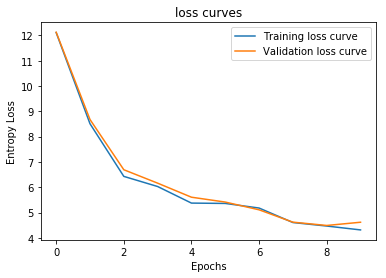

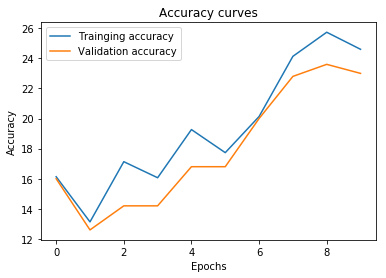

In [34]:
pad =0
stride =2
f =3
model = Neural_Network(2,900, [450,160,10],36,1,5)
# try different combinations of epochs and learning rate
model.train(trainX, trainY,pad =0 ,stride =2,f =3,Pmode = "max", epochs = 10, learningRate = .01,gr_size = 60, validationX = validX, validationY = validY)
# model.test_accuracy(testX,testY, pad, stride, f)

In [34]:
pad =0
stride =2
f =3
model = Neural_Network(2,900, [450,160,10],36,1,5)
# try different combinations of epochs and learning rate
# model.loadModel("g")

(36, 5, 5, 1)
(36, 1, 1, 1)


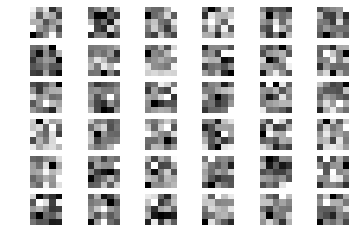

In [35]:
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.axis('off')
    plt.imshow(model.cnnfilters[i,:,:,0], cmap = 'gray')

In [ ]:
pad =0
stride =2
f =3
model = Neural_Network(2,900, [450,160,10],36,1,5)
# try different combinations of epochs and learning rate
# model.loadModel("g")
model.train(trainX, trainY,pad =0 ,stride =2,f =3,Pmode = "max", epochs = 15, learningRate = .01,gr_size = 60, validationX = validX, validationY = validY)
# model.test_accuracy(testX,testY, pad, stride, f,"max")

(36, 5, 5, 1)
(36, 1, 1, 1)
1.8507021374834909  ...............................................
epoch:  0 440623.36127159966 >> T error:  4.240391471606442 V error:  4.272842122193739 T acc:  29.296511370184845 V acc : 28.763297872340427
1.7528055818213357  ...............................................
epoch:  1 440626.0456306143 >> T error:  2.821749721781513 V error:  2.8484271573738265 T acc:  45.4009486236092 V acc : 45.86436170212766
2.0530946546792985  ...............................................
epoch:  2 440628.50872310885 >> T error:  2.181999594176084 V error:  2.204232258757271 T acc:  54.7054390708808 V acc : 54.56117021276595
1.7492214868466058  ...............................................
epoch:  3 440631.3135241423 >> T error:  1.8797118878846748 V error:  1.928960316259687 T acc:  59.763287379759745 V acc : 59.25531914893617
1.8614036784569423  ...............................................
epoch:  4 440633.81555023213 >> T error:  1.669038248772861 V error:  1

In [11]:
pad =0
stride =2
f =3
model = Neural_Network(2,900, [450,160,10],36,1,5)
# try different combinations of epochs and learning rate
# model.loadModel("g")

(36, 5, 5, 1)
(36, 1, 1, 1)
[4.240391471606442, 2.821749721781513, 2.181999594176084, 1.8797118878846748, 1.669038248772861, 1.4380637743618556, 1.3623056070697186, 1.3656107912595983, 1.2651314346753044, 1.2173448627634926]


In [ ]:
model.train(trainX, trainY,pad =0 ,stride =2,f =3,Pmode = "max", epochs = 4, learningRate = .01,gr_size = 60, validationX = validX, validationY = validY)
# model.test_accuracy(testX,testY, pad, stride, f,"max")

1.923042945133315  ...............................................
epoch:  0 >> T error:  1.3623056070697186 V error:  1.4510918178704009 T acc:  69.83022297087636 V acc : 68.36436170212767
1.9006548327869839  ...............................................
epoch:  1 >> T error:  1.3656107912595983 V error:  1.452271192506627 T acc:  70.25134092823264 V acc : 68.00531914893617
1.9379855019516414  ...............................................
epoch:  2 >> T error:  1.2651314346753044 V error:  1.3620270452712617 T acc:  72.17518507026021 V acc : 70.65159574468085


In [22]:
model.test_accuracy(testX,testY, pad, stride, f,"max")

test accuracy 70.48180924287118


Early stopping on 10 epochs only, with reported accuracies

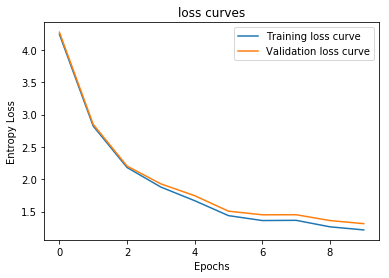

In [13]:
plt.plot(range(len(model.errorTrain)), model.errorTrain, label = 'Training loss curve')
plt.legend()
plt.title('loss curves')
plt.plot(range(len(model.errorValid)), model.errorValid, label = 'Validation loss curve')
plt.legend()
plt.xlabel('Epochs') 
plt.ylabel('Entropy Loss') 
plt.show()

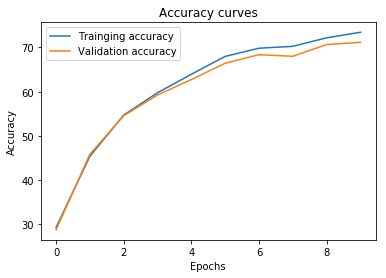

In [14]:
plt.plot(range(len(model.TraingingAccuracy)), model.TraingingAccuracy, label = 'Trainging accuracy')
plt.plot(range(len(model.ValidationAccuracy)), model.ValidationAccuracy, label = 'Validation accuracy')
plt.legend()
plt.title('Accuracy curves' )
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.show()